In [1]:
# load densenet arch and make an eye detector (idea: with attention regions)

In [2]:
import os
import sys

sys.path.append('../')

import cv2
import json
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import load_image

In [3]:
from tflow.DenseNet10.keras_fc_densenet import _create_fc_dense_net
from tflow.DenseNet10.keras_fc_densenet import _dense_block, _transition_down_block

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Input, BatchNormalization, Activation, Dropout, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

In [5]:
# make a better way to store all this in a config.json file to be readable as "experiment" counter # save a list of this json objects

img_input = Input((224, 224, 3))
bn_momentum = 0.9
concat_axis = -1
data_format = "channels_last"
dropout_rate = 0.2
weight_decay = 1e-4
transition_pooling = 'max'

# Initial convolution
with tf.name_scope("Initial"):
    x = Conv2D(
        48,
        (3, 3),
        kernel_initializer="he_normal",
        padding="same",
        use_bias=False,
        kernel_regularizer=l2(weight_decay),
        data_format=data_format,
    )(img_input)
    x = BatchNormalization(
        momentum=bn_momentum, axis=concat_axis, epsilon=1.1e-5
    )(x)
    x = Activation("relu")(x)

2022-07-28 20:41:16.562738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 20:41:16.589917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 20:41:16.590345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-28 20:41:16.591064: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [6]:
# keeps track of the current number of feature maps
nb_filter = 42
growth_rate = 4
nb_dense_block = 4
nb_layers_per_block = 3
bottleneck_nb_layers = nb_layers_per_block
nb_layers = [nb_layers_per_block] * (2 * nb_dense_block + 1)

# collect skip connections on the downsampling path so that
# they can be concatenated with outputs on the upsampling path
skip_list = []

# Build the downsampling path by adding dense blocks and transition down blocks
for block_idx in range(nb_dense_block):
    x, nb_filter, _ = _dense_block(
        x,
        nb_layers[block_idx],
        nb_filter,
        growth_rate,
        bn_momentum=bn_momentum,
        dropout_rate=dropout_rate,
        data_format=data_format,
        block_prefix="DenseBlock_%i" % block_idx,
    )

    skip_list.append(x)
    x = _transition_down_block(
        x,
        nb_filter,
        weight_decay=weight_decay,
        bn_momentum=bn_momentum,
        transition_pooling=transition_pooling,
        data_format=data_format,
        block_prefix="TransitionDown_%i" % block_idx,
    )

x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Dense(32, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Dense(4, activation='sigmoid')(x)

In [7]:
model = Model(inputs=img_input, outputs=x)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 48  192        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Generator funct

In [9]:
# TODO: implement data augmentation for object detection

datapath = {
    'images_path': "/home/choppy/TOC/thesis-msc-2022/data/images/aws/bonafide/via_marked",
    'via_file': "/home/choppy/TOC/thesis-msc-2022/data/images/aws/bonafide/via_marked/via_region_data.json"
}

In [10]:
with open(datapath.get('via_file')) as f:
    data = json.load(f)
    images_tensor = []
    coords_tensor = []
    
    for key in data.keys():
        impath = os.path.join(datapath.get('images_path'), data[key].get('filename'))
        # need to get image shape to properly format regions
        # image = Image.open(impath)
        # im_width, im_height = image.size
                     
        regions = data[key]['regions']
        
        if regions: # will be a empty list or list of regions
            shape_attributes = regions[0]['shape_attributes'] # take the first because is the unique region on the image
            # load marks
            region_name = shape_attributes.get('name') # will return "rect". Not used
            x = shape_attributes.get('x')
            y = shape_attributes.get('y')
            width = shape_attributes.get('width')
            height = shape_attributes.get('height')
            
            # make array with batch size and coords
            coords = np.array([x, y, x+width, y+height])
            
            # append data to tensors
            images_tensor.append(impath)
            coords_tensor.append(coords)

In [11]:
images_tensor = tf.cast(images_tensor, dtype=tf.string)
coords_tensor = tf.cast(coords_tensor, dtype=tf.float32)

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((images_tensor, coords_tensor))

In [13]:
def _parse_function(impath, coords):
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    h_image = tf.shape(image_decoded)[0]
    w_image = tf.shape(image_decoded)[1]
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.
    
    coords = coords / [w_image, h_image, w_image, h_image] # image width, height
    return image, coords

In [14]:
dataset = dataset.map(_parse_function)
dataset = dataset.cache()
dataset = dataset.batch(1)

In [15]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [16]:
train_ds = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)
val_ds = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)

# Show first image from train set

2022-07-28 20:41:17.827842: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


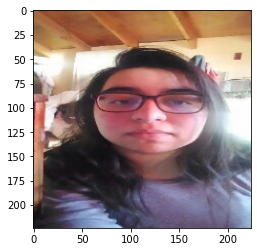

In [17]:
for im, coords in dataset.take(1):
    plt.imshow(im[0])
    print(coords[0])

# Train config

In [18]:
lr = 1e-4

# opt = tf.keras.optimizers.Adadelta(
#     learning_rate=lr,
#     rho=0.95,
#     epsilon=1e-07,
#     name='AdadeltaOpt',
# )

opt = tf.keras.optimizers.RMSprop(
    learning_rate=lr,
    rho=0.9,
    momentum=0.9,
    epsilon=1e-07,
    centered=False,
    name='RMSpropOpt',
)

model.compile(
    optimizer=opt,
    loss=tf.losses.MeanSquaredError(),
    metrics=['accuracy', 'mae', 'mse',]
)

# Callbacks

In [19]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=50,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=1e-15,
    ),
    
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=50,
    )
]

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    max_queue_size=10,
    workers=10,
    use_multiprocessing=True,
    callbacks=callbacks,
)

Epoch 1/1000


2022-07-28 20:41:20.035935: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-07-28 20:41:20.528876: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 20:41:20.529305: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 20:41:20.529325: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-28 20:41:20.529764: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 20:41:20.529808: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


44/44 [==============================] - 5s 29ms/step - loss: 0.1380 - accuracy: 0.4091 - mae: 0.2072 - mse: 0.0715 - val_loss: 0.0878 - val_accuracy: 1.0000 - val_mae: 0.1154 - val_mse: 0.0219 - lr: 1.0000e-04
Epoch 2/1000
44/44 [==============================] - 1s 22ms/step - loss: 0.1058 - accuracy: 0.5227 - mae: 0.1616 - mse: 0.0406 - val_loss: 0.0911 - val_accuracy: 1.0000 - val_mae: 0.1311 - val_mse: 0.0268 - lr: 1.0000e-04
Epoch 3/1000
44/44 [==============================] - 1s 22ms/step - loss: 0.0883 - accuracy: 0.7727 - mae: 0.1269 - mse: 0.0249 - val_loss: 0.0820 - val_accuracy: 1.0000 - val_mae: 0.1085 - val_mse: 0.0197 - lr: 1.0000e-04
Epoch 4/1000
44/44 [==============================] - 1s 22ms/step - loss: 0.0850 - accuracy: 0.8182 - mae: 0.1231 - mse: 0.0236 - val_loss: 0.0786 - val_accuracy: 1.0000 - val_mae: 0.1063 - val_mse: 0.0183 - lr: 1.0000e-04
Epoch 5/1000
44/44 [==============================] - 1s 22ms/step - loss: 0.0767 - accuracy: 0.9091 - mae: 0.0996 - 

In [21]:
# TODO: evaluate model with test data

In [22]:
model.evaluate(val_ds)

44/44 [==============================] - 0s 6ms/step - loss: 0.0073 - accuracy: 1.0000 - mae: 0.0648 - mse: 0.0073


[0.007268470246344805, 1.0, 0.06476552039384842, 0.007260818965733051]

In [23]:
model.save(filepath='eye_detector_model.hdf5')

In [24]:
new_model = tf.keras.models.load_model(filepath='eye_detector_model.hdf5')

In [25]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 48  192        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [26]:
# plot history with losses and metrics in two figures

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'mae', 'mse', 'val_loss', 'val_accuracy', 'val_mae', 'val_mse', 'lr'])

In [28]:
lr = history.history.pop('lr', None) # not used

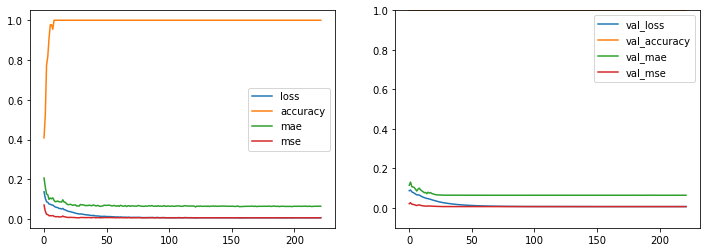

In [29]:
hist = history.history

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

for key in hist.keys():
    if 'val_' not in key:
        axes[0].plot(hist[key], label=key)
    else:
        axes[1].plot(hist[key], label=key)

axes[0].legend()
axes[1].legend()

plt.ylim([-0.1, 1])
plt.show()